In [1]:
sc.addPyFile("../Pattern_extraction/Pattern_Extractor.py")
sc.addPyFile("../Pattern_extraction/Additional_tools.py")


import time
from Pattern_Extractor import Pattern_Extractor as Extractor
from Additional_tools import print_test_results
import os


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#parameters
support = 0.001
interval = 30 #time window
maxDelta = 3 #how many spatial deltas
th = 0.5 #distance (seems in km)
window_size = 3 #how many time deltas

neighborhood_type = 'indegree'
n_neighbors = 0
extraction_type = 'Full-Increase' # Full-AlmostFull or Empty-AlmostEmpty or 'Full-Decrease' or 'Empty-Increase' or 'Full-Increase'
incr_dec_threshold = 1 # 0 for threshold > 0
wrap_states = True
state_change = False

In [3]:
status_path  = "datasets/SanFrancisco_status_train.csv"
stations_path = "bike_sharing/station.csv"
importance_path = "../../Datasets/edge_importance.csv"

ext = Extractor(interval, maxDelta, th, window_size, status_path, stations_path, spark, sc)

In [4]:
df = ext.extract_items(extraction_type=extraction_type, neighborhood_type=neighborhood_type,
                       n_neighbors=n_neighbors, incr_dec_threshold=incr_dec_threshold, 
                       wrap_states=wrap_states, state_change=state_change, importance_path=importance_path)

In [5]:
support = 0.001
prefix = ext.extract_frequent_items(df, support)

In [6]:
output_file = f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}/{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"

if not os.path.exists(f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}/"):
    os.makedirs(f"../../Results/Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}/")

ext.save_classification_patterns(prefix, output_file)

../../Results/Classification_patterns/Full-Increase_wrapped/0_1_30_500_0.001(3-3).txt  saved successfully.


In [7]:
# CAREFUL
# next directories needs to be modified every time

#!hdfs dfs -mkdir ./Classification_patterns/Full-Increase_wrapped/
!hdfs dfs -put "../../Results/Classification_patterns/Full-Increase_wrapped/0_1_30_500_0.001(3-3).txt" ./Classification_patterns/Full-Increase_wrapped/

In [8]:
!hdfs dfs -ls Classification_patterns/Full-Increase_wrapped

Found 3 items
-rw-r-----   3 s287791 students       4506 2022-04-21 17:43 Classification_patterns/Full-Increase_wrapped/0_1_30_500_0.001(3-3).txt
-rw-r-----   3 s287791 students   11303955 2022-04-21 13:24 Classification_patterns/Full-Increase_wrapped/10_1_30_500_0.001(3-3).txt
-rw-r-----   3 s287791 students    2417164 2022-04-21 15:06 Classification_patterns/Full-Increase_wrapped/Dist_1_30_500_0.001(3-3).txt


In [9]:
status_path_test  = "datasets/SanFrancisco_status_test.csv"

test_ext = Extractor(interval, maxDelta, th, window_size, status_path_test, stations_path, spark, sc)
df_t = test_ext.extract_items(extraction_type=extraction_type, neighborhood_type=neighborhood_type,
                       n_neighbors=n_neighbors, incr_dec_threshold=incr_dec_threshold, 
                       wrap_states=wrap_states, state_change=state_change, for_test=True,
                       importance_path=importance_path)

File:  ./Classification_patterns/Full-Increase_wrapped/0_1_30_500_0.001(3-3).txt


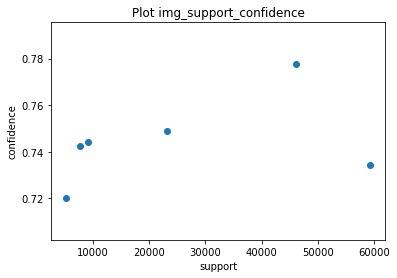

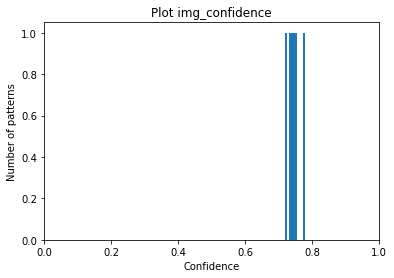

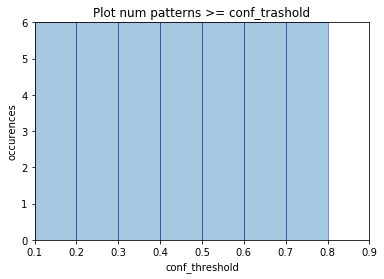

In [15]:
conf_threshold = 0.7
sup_threshold = 0
patterns_file = f"./Classification_patterns/{extraction_type}{'_wrapped' if wrap_states else ''}{'_stateChange' if state_change else ''}/{n_neighbors if neighborhood_type=='indegree' else 'Dist'}_{incr_dec_threshold}_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta}).txt"

print("File: ", patterns_file)

filtered_patterns = ext.filter_patterns_conf_sup(patterns_file, conf_threshold, sup_threshold, target='AlmostFull')
ext.print_patterns_stats(filtered_patterns)
rules = filtered_patterns.collect()

In [20]:
for match_threshold in [10, 20]:
    results = test_ext.test_rules(df_t, rules, match_threshold)
    print(match_threshold)
    print_test_results(results)

10


KeyError: 'TP'

In [21]:
#test_ext.logga(df_t, rules).filter(lambda x:x!=None).saveAsTextFile('logs')
results

{'FN': 25718, 'TN': 342203}

# Experimental results

$$patterns_file = "./Classification_patterns/Full-Decrease_wrapped/5_1_30_500_0.001(3-3).txt"$$

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9574071960122416

Precision score:
0.6670102064563317

Recall score:
0.780115094486352

F1 score:
0.7191426062333099

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9663600832776156

Precision score:
0.7590183667922183

Recall score:
0.7600513259195893

F1 score:
0.7595344951526102

$$patterns_file = "./Classification_patterns/Full-Decrease_wrapped/10_1_30_500_0.001(3-3).txt"$$

**conf threshold = 0.2
sup threshold = 0
match threshold = 1**

Accuracy score:
0.7642941980653876

Precision score:
0.21961577350859454

Recall score:
0.9290352684994362

F1 score:
0.35525288646687536

**conf threshold = 0.2
sup threshold = 0
match threshold = 2**

Accuracy score:
0.7881710873565281

Precision score:
0.23782795979637122

Recall score:
0.9210250029163588

F1 score:
0.37803846460777274

**conf threshold = 0.2
sup threshold = 0
match threshold = 3**

Accuracy score:
0.808995757333616

Precision score:
0.2554256545364729

Recall score:
0.9047711630439009

F1 score:
0.398383727699209

**conf threshold = 0.2
sup threshold = 0
match threshold = 4**

Accuracy score:
0.8147903535736515

Precision score:
0.2348942126245017

Recall score:
0.7308784072792316

F1 score:
0.35552697283801166

**conf threshold = 0.2
sup threshold = 0
match threshold = 5**

Accuracy score:
0.8191009678497754

Precision score:
0.23165170768887078

Recall score:
0.6854609791188708

F1 score:
0.3462785078672874

**conf threshold = 0.2
sup threshold = 0
match threshold = 50**

Accuracy score:
0.9146710370750879

Precision score:
0.3693391016200295

Recall score:
0.3120503946805615

F1 score:
0.3382864369269681

**conf threshold = 0.3
sup threshold = 0
match threshold = 1**

Accuracy score:
0.932253233640186

Precision score:
0.5095825357982215

Recall score:
0.8178247851615663

F1 score:
0.6279146141215106

**conf threshold = 0.3
sup threshold = 0
match threshold = 3**

Accuracy score:
0.9392029440462698

Precision score:
0.5439254788769352

Recall score:
0.8060426954932535

F1 score:
0.6495370297836339

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9579321010303619

Precision score:
0.6712952119650685

Recall score:
0.7801454290935956

F1 score:
0.7216387310265449

**conf threshold = 0.5
sup threshold = 0
match threshold = 2**

Accuracy score:
0.9589730627376477

Precision score:
0.6804621134896365

Recall score:
0.7787066920713924

F1 score:
0.7262770413621774

**conf threshold = 0.5
sup threshold = 0
match threshold = 3**

{'TN': 333054, 'TP': 19844, 'FN': 5873, 'FP': 9158} 

Accuracy score:
0.9591470093414762

Precision score:
0.6842286738845597

Recall score:
0.7716296613135281

F1 score:
0.7253056525155797

**conf threshold = 0.5
sup threshold = 0
match threshold = 4**

{'TN': 333538, 'TP': 15378, 'FN': 10339, 'FP': 8674} 

Accuracy score:
0.9483242690845245

Precision score:
0.6393647097954432

Recall score:
0.597970214255162

F1 score:
0.6179750447065443

**conf threshold = 0.5
sup threshold = 0
match threshold = 5**

{'TN': 333761, 'TP': 14461, 'FN': 11256, 'FP': 8451} 

Accuracy score:
0.9464380355992597

Precision score:
0.6311539804469274

Recall score:
0.5623128669751526

F1 score:
0.5947479898825804

**conf threshold = 0.5
sup threshold = 0
match threshold = 10**

Accuracy score:
0.942032294274167

Precision score:
0.6173843273602567

Recall score:
0.4488081813586344

F1 score:
0.519769431685130

**conf threshold = 0.5
sup threshold = 0
match threshold = 20**

{'TN': 336855, 'TP': 8798, 'FN': 16919, 'FP': 5357} 

Accuracy score:
0.939455710204958

Precision score:
0.6215471564818086

Recall score:
0.34210833300929344

F1 score:
0.44131219903691815{'TN': 342209, 'TP': 2, 'FN': 25715, 'FP': 3}

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

Accuracy score:
0.966368511316042

Precision score:
0.7590773173857326

Recall score:
0.7600808803515184

F1 score:
0.7595787673894459

**conf threshold = 0.7
sup threshold = 0
match threshold = 2**

{'TN': 336366, 'TP': 18684, 'FN': 7033, 'FP': 5846} 

Accuracy score:
0.964995963895208

Precision score:
0.7616795760293518

Recall score:
0.7265233114282381

F1 score:
0.7436861902203116

**conf threshold = 0.7
sup threshold = 0
match threshold = 3**

{'TN': 339746, 'TP': 6712, 'FN': 19005, 'FP': 2466} 

Accuracy score:
0.9416436323312378

Precision score:
0.7313140117672695

Recall score:
0.2609946727845394

F1 score:
0.3846969479868176

**conf threshold = 0.7
sup threshold = 0
match threshold = 4**

{'TN': 339840, 'TP': 6378, 'FN': 19339, 'FP': 2372} 

Accuracy score:
0.9409913325668811

Precision score:
0.7289142857142857

Recall score:
0.24800715480032665

F1 score:
0.37009313256158066

**conf threshold = 0.7
sup threshold = 0
match threshold = 5**

{'TN': 339871, 'TP': 6243, 'FN': 19474, 'FP': 2341} 

Accuracy score:
0.9407086693356599

Precision score:
0.7272833178005592

Recall score:
0.2427577089085041

F1 score:
0.3640127109996793

**conf threshold = 0.7
sup threshold = 0
match threshold = 10**

Accuracy score:
0.937797781637218

Precision score:
0.7093006062398344

Recall score:
0.18653031068942721

F1 score:
0.2953817733990148

**conf threshold = 0.7
sup threshold = 0
match threshold = 20**

Accuracy score:
0.933171889141655

Precision score:
0.68133633151301

Recall score:
0.08247462767818953

F1 score:
0.14713839750260146

**conf threshold = 0.7
sup threshold = 0
match threshold = 30**

Accuracy score:
0.9305789975783372

Precision score:
0.632375189107413

Recall score:
0.016253839872457907

F1 score:
0.0316930775646372

**conf threshold = 0.7
sup threshold = 0
match threshold = 40**

Accuracy score:
0.9301767460569839

Precision score:
0.6238532110091743

Recall score:
0.0026441653381032004

F1 score:
0.005266010996670023

**conf threshold = 0.7
sup threshold = 0
match threshold = 50**

Accuracy score:
0.9301386952373963

Precision score:
0.8421052631578947

Recall score:
0.0006221565501419294

F1 score:
0.0012433944668946222

**conf threshold = 0.7
sup threshold = 0
match threshold = 55**

{'TN': 342209, 'TP': 2, 'FN': 25715, 'FP': 3} 

Accuracy score:
0.9301006444178088

Precision score:
0.4

Recall score:
7.776956876774118e-05

F1 score:
0.00015550890288469014

**conf threshold = 0.7
sup threshold = 0
match threshold = 60**

{'TN': 342212, 'TP': 2, 'FN': 25715, 'FP': 0}

Accuracy score:
0.9301087981648634

Precision score:
1.0

Recall score:
7.776956876774118e-05

F1 score:
0.00015552704226447372

$$patterns_file = "./Classification_patterns/Full-Decrease_wrapped/20_1_30_500_0.001(3-3).txt"$$

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9583969776859729

Precision score:
0.6752761314655172

Recall score:
0.779756581249757

F1 score:
0.7237651814556151

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9663686027233441

Precision score:
0.7590773173857326

Recall score:
0.7600808803515184

F1 score:
0.7595787673894459

**conf threshold = 0.8
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9317478868262985

Precision score:
0.7669902912621359

Recall score:
0.03379087762958354

F1 score:
0.06472998137802607

$$patterns_file = "./Classification_patterns/Full-Decrease_wrapped/Dist_1_30_500_0.001(3-3).txt"$$

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9587937922974479

Precision score:
0.6788303855797249

Recall score:
0.7790566551308473

F1 score:
0.7254983614274593

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9663604489984507

Precision score:
0.7589888949289431

Recall score:
0.7600808803515184

F1 score:
0.7595344951526102

$$patterns_file = "./Classification_patterns/Full-Decrease_wrapped_stateChange/10_1_30_500_0.001(3-3).txt"$$

**conf threshold = 0.5
sup threshold = 0**

No rules survive

$$patterns_file = "./Classification_patterns/Full-Decrease_wrapped_stateChange_Dist/10_1_30_500_0.001(3-3).txt"$$

**conf threshold = 0.5
sup threshold = 0**

No rules survive

$$patterns_file:  ./Classification_patterns/Full-AlmostFull_wrapped/10_1_30_500_0.001(3-3).txt$$

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9585267433273552

Precision score:
0.6769236358352103

Recall score:
0.8348118279569893

F1 score:
0.7476226778477711

**conf threshold = 0.5
sup threshold = 0
match threshold = 2**

Accuracy score:
0.9603168846924781

Precision score:
0.6912404686628232

Recall score:
0.8326164874551971

F1 score:
0.7553703891880907

**conf threshold = 0.5
sup threshold = 0
match threshold = 3**

Accuracy score:
0.9621004325350775

Precision score:
0.7318368745716244

Recall score:
0.7654121863799284

F1 score:
0.7482480728801681

**conf threshold = 0.5
sup threshold = 0
match threshold = 5**

{'FN': 13905, 'TP': 8415, 'FP': 3552, 'TN': 277456} 

Accuracy score:
0.9424484386538664

Precision score:
0.7031837553271496

Recall score:
0.37701612903225806

F1 score:
0.4908565928777671

**conf threshold = 0.5
sup threshold = 0
match threshold = 10**

{'FN': 15140, 'TP': 7180, 'FP': 2660, 'TN': 278348} 

Accuracy score:
0.9413176495410909

Precision score:
0.7296747967479674

Recall score:
0.3216845878136201

F1 score:
0.4465174129353233

**conf threshold = 0.5
sup threshold = 0
match threshold = 20**

{'FN': 20353, 'FP': 722, 'TP': 1967, 'TN': 280286} 

Accuracy score:
0.9305207564089039

Precision score:
0.7314986984008925

Recall score:
0.08812724014336917

F1 score:
0.15730337078651685

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9623905475261103

Precision score:
0.7089140756624291

Recall score:
0.8294802867383513

F1 score:
0.7644727062515484

**conf threshold = 0.7
sup threshold = 0
match threshold = 2**

Accuracy score:
0.9629444034180821

Precision score:
0.7404305181841854

Recall score:
0.7643817204301075

F1 score:
0.7522155107799479

**conf threshold = 0.7
sup threshold = 0
match threshold = 5**

{'FN': 14614, 'TP': 7706, 'FP': 2768, 'TN': 278240} 

Accuracy score:
0.9426956957484967

Precision score:
0.7357265610082108

Recall score:
0.34525089605734766

F1 score:
0.4699640178081356

**conf threshold = 0.7
sup threshold = 0
match threshold = 10**

Accuracy score:
0.9313779143369554

Precision score:
0.7151844438089792

Recall score:
0.11205197132616487

F1 score:
0.19374830538017587


**conf threshold = 0.7
sup threshold = 0
match threshold = 20**

{'FN': 21095, 'TP': 1225, 'FP': 352, 'TN': 280656} 

Accuracy score:
0.9292943612195379

Precision score:
0.7767913760304376

Recall score:
0.054883512544802865

F1 score:
0.10252332928819517

**conf threshold = 0.8
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9688291222702817

Precision score:
0.7724827381708815

Recall score:
0.8170250896057347

F1 score:
0.7941298147059463

**conf threshold = 0.9
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9264360692056124

Precision score:
0.6875

Recall score:
0.000492831541218638

F1 score:
0.0009849570200573066

$$patterns_file:  ./Classification_patterns/Full-AlmostFull_wrapped/Dist_1_30_500_0.001(3-3).txt$$

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

Accuracy score:
0.955427787741323

Precision score:
0.6534705266829438

Recall score:
0.8393817204301075

F1 score:
0.7348499705824671

**conf threshold = 0.5
sup threshold = 0
match threshold = 5**

{'TN': 275708, 'TP': 11479, 'FN': 10841, 'FP': 5300} 

Accuracy score:
0.9467869764743116

Precision score:
0.6841289707372311

Recall score:
0.5142921146953405

F1 score:
0.5871761426123431

**conf threshold = 0.5
sup threshold = 0
match threshold = 10**

{'TN': 276634, 'TP': 9995, 'FN': 12325, 'FP': 4374} 

Accuracy score:
0.9449473836902627

Precision score:
0.695594682998121

Recall score:
0.44780465949820786

F1 score:
0.5448499550273923

**conf threshold = 0.5
sup threshold = 0
match threshold = 20**

{'TN': 279328, 'TP': 4149, 'FN': 18171, 'FP': 1680} 

Accuracy score:
0.9345559921932693

Precision score:
0.7117858980957282

Recall score:
0.18588709677419354

F1 score:
0.29478844719172975

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

Accuracy score:
0.9647147642156345

Precision score:
0.7305600762116461

Recall score:
0.8245967741935484

F1 score:
0.7747353355923643

**conf threshold = 0.7
sup threshold = 0
match threshold = 2**

Accuracy score:
0.9634125435172487

Precision score:
0.7348878097789685

Recall score:
0.7865143369175627

F1 score:
0.7598251385041551

**conf threshold = 0.7
sup threshold = 0
match threshold = 3**

Accuracy score:
0.950347478636987

Precision score:
0.7166477645794783

Recall score:
0.5379032258064517

F1 score:
0.6145420111074144

**conf threshold = 0.7
sup threshold = 0
match threshold = 5**

{'TN': 277131, 'TP': 10134, 'FN': 12186, 'FP': 3877} 

Accuracy score:
0.9470441238527271

Precision score:
0.7232888444793376

Recall score:
0.45403225806451614

F1 score:
0.5578706889433267

**conf threshold = 0.7
sup threshold = 0
match threshold = 10**

{'TN': 279285, 'TP': 4396, 'FN': 17924, 'FP': 1723} 

Accuracy score:
0.9352285314906635

Precision score:
0.7184180421637523

Recall score:
0.19695340501792113

F1 score:
0.30915292380182147

**conf threshold = 0.7
sup threshold = 0
match threshold = 20**

{'TN': 280324, 'TP': 2248, 'FN': 20072, 'FP': 684} 

Accuracy score:
0.9315724232513978

Precision score:
0.7667121418826739

Recall score:
0.1007168458781362

F1 score:
0.1780453033423095

$$patterns_file: ./Classification_patterns/Full-Increase_wrapped/10_1_30_500_0.001(3-3).txt$$


**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

{'TP': 20189, 'FN': 5528, 'FP': 11571, 'TN': 330642} 

Accuracy score:
0.9535264860163618

Precision score:
0.6356738035264483

Recall score:
0.7850449119259634

F1 score:
0.7025070897924387


**conf threshold = 0.5
sup threshold = 0
match threshold = 5**

{'TP': 16889, 'FN': 8828, 'FP': 10051, 'TN': 332162} 

Accuracy score:
0.948688609246324

Precision score:
0.6269116555308092

Recall score:
0.6567251234591904

F1 score:
0.6414721689424009

**conf threshold = 0.5
sup threshold = 0
match threshold = 10**

{'TP': 15148, 'FN': 10569, 'FP': 8862, 'TN': 333351} 

Accuracy score:
0.9471883238659528

Precision score:
0.6309037900874636

Recall score:
0.5890267138468718

F1 score:
0.6092464858125365

**conf threshold = 0.5
sup threshold = 0
match threshold = 20**

{'TP': 11334, 'FN': 14383, 'FP': 7223, 'TN': 334990} 

Accuracy score:
0.9412768733182942

Precision score:
0.6107668265344613

Recall score:
0.4407201462067893

F1 score:
0.5119934950535303

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

{'TP': 19547, 'FN': 6170, 'FP': 6226, 'TN': 335987} 

Accuracy score:
0.9663088087407931

Precision score:
0.7584293640631669

Recall score:
0.7600808803515184

F1 score:
0.7592542241211885

**conf threshold = 0.7
sup threshold = 0
match threshold = 5**

{'TP': 12535, 'FN': 13182, 'FP': 4411, 'TN': 337802} 

Accuracy score:
0.9521838393172615

Precision score:
0.7397025846807507

Recall score:
0.48742077225181785

F1 score:
0.5876286243349037

**conf threshold = 0.7
sup threshold = 0
match threshold = 10**

{'TP': 8143, 'FN': 17574, 'FP': 3310, 'TN': 338903} 

Accuracy score:
0.9432392031092871

Precision score:
0.7109927529904828

Recall score:
0.3166387992378582

F1 score:
0.43814904492870593

**conf threshold = 0.7
sup threshold = 0
match threshold = 20**

{'TP': 4823, 'FN': 20894, 'FP': 2093, 'TN': 340120} 

Accuracy score:
0.9375234419590683

Precision score:
0.6973684210526315

Recall score:
0.18754131508340785

F1 score:
0.29559035332332295

$$patterns_file: ./Classification_patterns/Full-Increase_wrapped/Dist_1_30_500_0.001(3-3).txt$$


**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

{'TP': 20244, 'FN': 5473, 'FP': 12034, 'TN': 330179} 

Accuracy score:
0.95241757943087

Precision score:
0.6271764049817213

Recall score:
0.7871835750670763

F1 score:
0.6981291490645746

**conf threshold = 0.5
sup threshold = 0
match threshold = 5**

{'TP': 17726, 'FN': 7991, 'FP': 10755, 'TN': 331458} 

Accuracy score:
0.949050091049928

Precision score:
0.6223798321688143

Recall score:
0.6892716879884901

F1 score:
0.6541200782316691

**conf threshold = 0.5
sup threshold = 0
match threshold = 10**

{'TP': 16424, 'FN': 9293, 'FP': 9806, 'TN': 332407} 

Accuracy score:
0.9480906694208138

Precision score:
0.626153259626382

Recall score:
0.6386436987206906

F1 score:
0.6323368048202975

**conf threshold = 0.5
sup threshold = 0
match threshold = 20**

{'TP': 12918, 'FN': 12799, 'FP': 8333, 'TN': 333880} 

Accuracy score:
0.9425651618514391

Precision score:
0.6078772763634652

Recall score:
0.5023136446708403

F1 score:
0.5500766479305058

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

{'TP': 19547, 'FN': 6170, 'FP': 6204, 'TN': 336009} 

Accuracy score:
0.9663686027233441

Precision score:
0.7590773173857326

Recall score:
0.7600808803515184

F1 score:
0.7595787673894459

**conf threshold = 0.7
sup threshold = 0
match threshold = 5**

{'TP': 14594, 'FN': 11123, 'FP': 5006, 'TN': 337207} 

Accuracy score:
0.9561628570652027

Precision score:
0.7445918367346939

Recall score:
0.5674845432982074

F1 score:
0.6440850012136725

**conf threshold = 0.7
sup threshold = 0
match threshold = 10**

{'TP': 10359, 'FN': 15358, 'FP': 4091, 'TN': 338122} 

Accuracy score:
0.9471394015165928

Precision score:
0.716885813148789

Recall score:
0.40280748143251544

F1 score:
0.5157965494062289

**conf threshold = 0.7
sup threshold = 0
match threshold = 20**

{'TP': 6542, 'FN': 19175, 'FP': 2708, 'TN': 339505} 

Accuracy score:
0.9405240127198108

Precision score:
0.7072432432432433

Recall score:
0.2543842594392814

F1 score:
0.37418137100694937

$$patterns_file: ./Classification_patterns/Full-Increase_wrapped/0_1_30_500_0.001(3-3).txt$$

**conf threshold = 0.5
sup threshold = 0
match threshold = 1**

{'TP': 19874, 'FN': 5844, 'FP': 7953, 'TN': 334250} 

Accuracy score:
0.9625001019240543

Precision score:
0.7141984403636755

Recall score:
0.7727661559996889

F1 score:
0.742328882248576

**conf threshold = 0.5
sup threshold = 0
match threshold = 5**

{'TP': 8850, 'FN': 16868, 'FP': 3906, 'TN': 338297} 

Accuracy score:
0.9435367918656451

Precision score:
0.69379115710254

Recall score:
0.34411696088342797

F1 score:
0.46005094349430786

**conf threshold = 0.5
sup threshold = 0
match threshold = 10**

{'TP': 2011, 'FN': 23707, 'FP': 961, 'TN': 341242} 

Accuracy score:
0.932952998062084

Precision score:
0.6766487213997309

Recall score:
0.07819426082899136

F1 score:
0.14018821889159985

**conf threshold = 0.5
sup threshold = 0
match threshold = 20**

No Positive Predictions

**conf threshold = 0.7
sup threshold = 0
match threshold = 1**

{'TP': 19547, 'FN': 6171, 'FP': 6203, 'TN': 336000} 

Accuracy score:
0.9663677800397368

Precision score:
0.7591067961165049

Recall score:
0.7600513259195893

F1 score:
0.7595787673894459

**conf threshold = 0.7
sup threshold = 0
match threshold = 5**

{'TP': 2011, 'FN': 23707, 'FP': 961, 'TN': 341242} 

Accuracy score:
0.932952998062084

Precision score:
0.6766487213997309

Recall score:
0.07819426082899136

F1 score:
0.14018821889159985

**conf threshold = 0.7
sup threshold = 0
match threshold = 10**

No Positive Predictions

**conf threshold = 0.7
sup threshold = 0
match threshold = 20**

No Positive Predictions